In [1]:
import json
prettyprint = lambda x: json.dumps(x, indent=4, sort_keys=True)

## Exploring the data first

In [2]:
#This assumes you have all_plans_with_wires.json in the same folder as the notebook.
with open('all_plans_with_wires.json', 'r') as f:
    aq_plans_json = json.load(f)

In [3]:
print(len(aq_plans_json)) #9616
print(prettyprint(aq_plans_json[9615]))

9616
{
    "created_at": "2019-05-23T16:45:31.000-07:00",
    "id": 33674,
    "operations": [
        {
            "created_at": "2019-05-23T16:47:56.000-07:00",
            "field_values": [
                {
                    "rid": 6753363,
                    "role": "input",
                    "sample": {
                        "rid": 6753367,
                        "sample_type_id": 5
                    },
                    "sample_type": 5
                },
                {
                    "rid": 6753364,
                    "role": "input",
                    "sample": {
                        "rid": 6753369,
                        "sample_type_id": 5
                    },
                    "sample_type": 5
                },
                {
                    "rid": 6753365,
                    "role": "output",
                    "sample": {
                        "rid": 6753371,
                        "sample_type_id": 5
                    },
   

In [4]:
from pandas.io.json import json_normalize
operations_df = json_normalize(aq_plans_json, 
                       record_path='operations', 
                       meta=['id', 'status'],
                       record_prefix='op.')

In [5]:
print(operations_df['id'].nunique()) #should be 9616, not sure how we lost 14 plans

9602


In [6]:
operations_df.head(5)

,op.created_at,op.field_values,op.id,op.operation_type,op.operation_type_id,op.rid,op.status,op.updated_at,op.user_id,id,status
0,2017-07-13T08:29:06.000-07:00,"[{'rid': 19237, 'role': 'output', 'sample': {'...",17,Cloning,48,19235,done,2017-07-13T08:50:43.000-07:00,66,9,None
1,2017-07-13T08:29:06.000-07:00,"[{'rid': 19247, 'role': 'output', 'sample': {'...",18,Cloning,48,19245,done,2017-07-13T08:50:43.000-07:00,66,10,None
2,2017-07-13T08:58:15.000-07:00,"[{'rid': 19279, 'role': 'input', 'sample': {'r...",27,Cloning,20,19270,error,2017-07-13T09:17:41.000-07:00,17,13,None
3,2017-07-13T08:58:15.000-07:00,"[{'rid': 19292, 'role': 'input', 'sample': {'r...",28,Cloning,19,19271,error,2017-07-13T09:17:41.000-07:00,17,13,None
4,2017-07-13T08:58:15.000-07:00,"[{'rid': 19304, 'role': 'input', 'sample': {'r...",29,Cloning,18,19272,error,2017-07-13T09:17:41.000-07:00,17,13,None


In [7]:
operations_df = operations_df.drop(columns=['op.created_at', 'op.field_values', 'op.rid', 'op.status', 'op.updated_at']) # drop irrelevant columns
operations_df = operations_df.rename(index=str, columns={"op.operation_type": "op.category"}) #rename for clarity
print(operations_df['id'].nunique())
operations_df.head(5)

9602


,op.id,op.category,op.operation_type_id,op.user_id,id,status
0,17,Cloning,48,66,9,None
1,18,Cloning,48,66,10,None
2,27,Cloning,20,17,13,None
3,28,Cloning,19,17,13,None
4,29,Cloning,18,17,13,None


## Filter plans by status

In [8]:
# All possible plan statuses 
print(operations_df['status'].unique()) # [None, 'planning', 'template', 'system_template']

# Find "real" plans by filtering out any plans that are "planning" or templates
real_operations_df = operations_df.loc[operations_df['status'].isnull()]
print(real_operations_df['id'].nunique()) #8343

[None 'template' 'planning' 'system_template']
8343


## Analyze "islands" (plans with one operation)

In [9]:
op_counts_df = real_operations_df.groupby('id')['op.operation_type_id'].nunique().reset_index()
island_list = op_counts_df.loc[op_counts_df['op.operation_type_id'] == 1]['id'] #the op id here is actually a count
islands = real_operations_df[real_operations_df.id.isin(list(island_list))]['op.operation_type_id'].unique()
print(len(islands))
print(islands)

171
[ 48  22  18  19  33  24  17  38  31  21  34  25  23  58  28  42  64  65
  20  59  41  91 146  87 178  29  37  92 145 179  83  90  55 172 174  30
 186  82 197 203 204 195 208  49 196 213 219  89  74  75 137 222 223  73
 224 220 200  85  77  71  76 283 279 278 289 344  72 323  84 290 332 355
 212 337 228 259 284 258 262 362 361 371 379 266 272 375 381 393 394 392
 395 267 397 273  88 406 408 410 414 384 427 428 271 430 441 407 440 445
 443 444 401 447 446 331 442 412 376 453 274 275 199 452 374 456 459 462
 467 365 466 373 363 479 455 454 482 485 486 496 490 519 494 524 329  86
  78 565 566 545 571 548 575 562 265 596 506 606 607 399 609 605 264 534
 584 366 637 411 610 515 503 640 638]


In [10]:
# This is a list of all operation types in Aquarium
with open('aquarium-operations.json', 'r') as f:
    aq_ops = json.load(f)

print(prettyprint(aq_ops[0]))

{
    "category": "Cloning",
    "created_at": "2017-07-12T19:25:38.000-07:00",
    "deployed": true,
    "field_types": [
        {
            "allowable_field_types": [
                {
                    "created_at": "2017-07-12T19:25:38.000-07:00",
                    "field_type_id": 84,
                    "id": 64,
                    "object_type": {
                        "cleanup": "No cleanup information",
                        "columns": 12,
                        "cost": 1.0,
                        "created_at": "2014-08-28T17:19:55.000-07:00",
                        "data": "  {\r\n    \"materials\": 10.48,\r\n    \"labor\": 10\r\n  }",
                        "description": "Stripwell",
                        "handler": "collection",
                        "id": 440,
                        "image": "",
                        "max": 10000,
                        "min": 0,
                        "name": "Stripwell",
                        "prefix": "",
   

In [11]:
import pandas as pd
op_types_df = pd.DataFrame.from_dict(aq_ops)
op_types_df.head(5)

,category,created_at,deployed,field_types,id,name,on_the_fly,rid,updated_at
0,Cloning,2017-07-12T19:25:38.000-07:00,True,[{'allowable_field_types': [{'created_at': '20...,15,Run Gel,False,425,2017-07-12T19:26:14.000-07:00
1,Cloning,2017-07-12T19:25:38.000-07:00,True,[{'allowable_field_types': [{'created_at': '20...,16,Extract Gel Slice,False,426,2017-07-12T19:26:35.000-07:00
2,Cloning,2017-07-12T19:25:38.000-07:00,True,[{'allowable_field_types': [{'created_at': '20...,17,Pour Gel,True,427,2017-07-12T19:26:29.000-07:00
3,Cloning,2017-07-12T19:25:38.000-07:00,False,[{'allowable_field_types': [{'created_at': '20...,18,Send to Sequencing (old),False,428,2017-09-07T12:31:04.000-07:00
4,Cloning,2017-07-12T19:25:38.000-07:00,False,[{'allowable_field_types': [{'created_at': '20...,19,Upload Sequencing Results (old-old),False,429,2017-09-20T21:39:23.000-07:00


In [12]:
island_names = op_types_df[op_types_df['id'].isin(islands)]['name']
island_names

2                                 Pour Gel
3                 Send to Sequencing (old)
4      Upload Sequencing Results (old-old)
5            Make Glycerol Stock (old-old)
6                             Order Primer
                      ...                 
383                         Sample Factory
384                             Make Media
405        Purification Buffer Preparation
406               Lysis Buffer Preparation
408                     Make IPTG Aliquots
Name: name, Length: 171, dtype: object

## Filter islands

In [13]:
real_operations_without_islands_df = real_operations_df[~real_operations_df.id.isin(list(island_list))]
NUM_REAL_PLANS = real_operations_without_islands_df['id'].nunique() #5,969 plans
NUM_REAL_PLANS

5969

In [14]:
# get some basic stats of the final dataset we're working with
ops_per_plan = real_operations_without_islands_df.groupby("id")['op.id'].nunique()
print("mean:", ops_per_plan.mean()) #~14
print("standard dev:", ops_per_plan.std()) #~27
print("max:", ops_per_plan.max()) #643
print("id of plan with most operations:", ops_per_plan.idxmax()) #id of the plan with the most operations
print("min:", ops_per_plan.min()) #2
print("mode:", ops_per_plan.mode()) #3

mean: 14.235047746691238
standard dev: 27.03989713118704
max: 643
id of plan with most operations: 30442
min: 2
mode: 0    3
dtype: int64


In [15]:
real_operations_without_islands_df.head(5)

,op.id,op.category,op.operation_type_id,op.user_id,id,status
2,27,Cloning,20,17,13,None
3,28,Cloning,19,17,13,None
4,29,Cloning,18,17,13,None
5,30,Cloning,30,17,13,None
6,31,Cloning,29,17,13,None


## Connected Components Approach

In [16]:
import networkx as nx
from itertools import chain

# Add every unique operation as a node to a networkx graph
G = nx.Graph()   
nodes = real_operations_without_islands_df['op.operation_type_id'].unique()
print(len(nodes))
G.add_nodes_from(nodes)

294


In [17]:
'''create a wires dataframe'''
from pandas.io.json import json_normalize
wires_df = json_normalize(aq_plans_json, record_path=['wires'])
wires_df = wires_df.drop(columns=['id', 'rid', 'sample']) # drop irrelevant columns
wires_df = wires_df.rename(index=str, columns={"from": "src_op_id", "to": "dest_op_id"}) #rename for clarity
wires_df.head(5)

,src_op_id,dest_op_id
0,28.0,27.0
1,29.0,28.0
2,28.0,27.0
3,30.0,29.0
4,29.0,28.0


In [18]:
import numpy as np
'''format the wires dataframe to get rid of undefined values'''
to_from_pairs_df = wires_df.drop_duplicates(subset=['src_op_id', 'dest_op_id']) #89459
to_from_pairs_df = to_from_pairs_df[~to_from_pairs_df.isin([np.nan, np.inf, -np.inf]).any(1)]
# fill in NaNs and cast from float to int
# to_from_pairs_df = to_from_pairs_df.fillna(value={'src_op_id': 0, 'dest_op_id': 0}) 
to_from_pairs_df = to_from_pairs_df.astype({"src_op_id": int, "dest_op_id": int})
# len(to_from_pairs)

In [19]:
'''left merge with destination to find op type'''
merged_to = wires_df.merge(real_operations_without_islands_df, left_on='dest_op_id', right_on='op.id', how='left')
merged_pairs_df = merged_to[['src_op_id', 'dest_op_id', 'op.operation_type_id']].reset_index()
merged_pairs_df = merged_pairs_df.rename(index=str, columns={"op.operation_type_id": "dest_op_type_id"}) #rename for clarity
merged_pairs_df.head(5)

,index,src_op_id,dest_op_id,dest_op_type_id
0,0,28.0,27.0,20.0
1,1,29.0,28.0,19.0
2,2,28.0,27.0,20.0
3,3,30.0,29.0,18.0
4,4,29.0,28.0,19.0


In [20]:
'''left merge with source to find op type'''
edge_pairs_df = merged_pairs_df.merge(real_operations_without_islands_df, left_on='src_op_id', right_on='op.id', how='left')
edge_pairs_df = edge_pairs_df[['src_op_id', 'dest_op_id', 'op.operation_type_id', 'dest_op_type_id', 'id']].reset_index()
edge_pairs_df = edge_pairs_df.rename(index=str, columns={"op.operation_type_id": "src_op_type_id", 'id': 'plan_id'}) #rename for clarity
edge_pairs_df.head(5)

,index,src_op_id,dest_op_id,src_op_type_id,dest_op_type_id,plan_id
0,0,28.0,27.0,19.0,20.0,13
1,1,29.0,28.0,18.0,19.0,13
2,2,28.0,27.0,19.0,20.0,13
3,3,30.0,29.0,30.0,18.0,13
4,4,29.0,28.0,18.0,19.0,13


In [21]:
edge_pairs_df.shape

(182113, 6)

In [22]:
pair_counts = edge_pairs_df.groupby(['src_op_type_id', 'dest_op_type_id']).size().reset_index()
weighted_edges = list(pair_counts.itertuples(index=False, name=None))
weighted_edges

[(15.0, 16.0, 5300),
 (16.0, 24.0, 5074),
 (16.0, 329.0, 28),
 (17.0, 15.0, 5334),
 (17.0, 538.0, 2),
 (18.0, 19.0, 228),
 (18.0, 20.0, 2),
 (19.0, 20.0, 92),
 (19.0, 38.0, 2),
 (20.0, 38.0, 2),
 (21.0, 22.0, 4288),
 (22.0, 18.0, 24),
 (22.0, 23.0, 1804),
 (22.0, 63.0, 44),
 (22.0, 84.0, 404),
 (22.0, 220.0, 68),
 (22.0, 270.0, 44),
 (22.0, 452.0, 12),
 (22.0, 467.0, 6),
 (22.0, 496.0, 2),
 (22.0, 534.0, 916),
 (23.0, 15.0, 2896),
 (23.0, 403.0, 42),
 (24.0, 23.0, 18),
 (24.0, 25.0, 1674),
 (24.0, 31.0, 14),
 (24.0, 84.0, 210),
 (24.0, 89.0, 12),
 (24.0, 198.0, 12),
 (24.0, 199.0, 22),
 (24.0, 275.0, 2),
 (24.0, 406.0, 116),
 (24.0, 411.0, 28),
 (24.0, 453.0, 2),
 (24.0, 455.0, 14),
 (24.0, 467.0, 4),
 (24.0, 496.0, 10),
 (24.0, 505.0, 28),
 (24.0, 529.0, 2),
 (24.0, 534.0, 54),
 (24.0, 548.0, 8),
 (24.0, 597.0, 64),
 (25.0, 23.0, 28),
 (25.0, 25.0, 6),
 (25.0, 26.0, 3362),
 (26.0, 27.0, 4076),
 (26.0, 627.0, 34),
 (27.0, 28.0, 4244),
 (28.0, 29.0, 4010),
 (28.0, 82.0, 54),
 (28.0, 449

In [23]:
G.add_weighted_edges_from(weighted_edges)

In [24]:
import min_k_cut as mc

mc.draw_graph(G)

/nix/store/x3w4brzmyqgrl3xd44zpfvvnrd3kjdc5-python3-3.7.4-env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/nix/store/x3w4brzmyqgrl3xd44zpfvvnrd3kjdc5-python3-3.7.4-env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


We run the k mincut algorithm many times over the range of 50% to 80% of the vertices so we pick a good test/train split 

In [25]:
contractable = mc.make_contractable(G)
num_nodes = len(G.nodes)
all_cuts = mc.run_many_over_range(contractable, 50, range(int(num_nodes*0.5),int(num_nodes*0.7)))

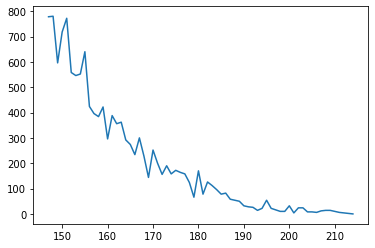

In [26]:
import matplotlib.pyplot as plt
(xs,ys) = list(zip(*map(lambda k: (k,all_cuts[k]['cut_size']), all_cuts)))
plt.plot(xs,ys)

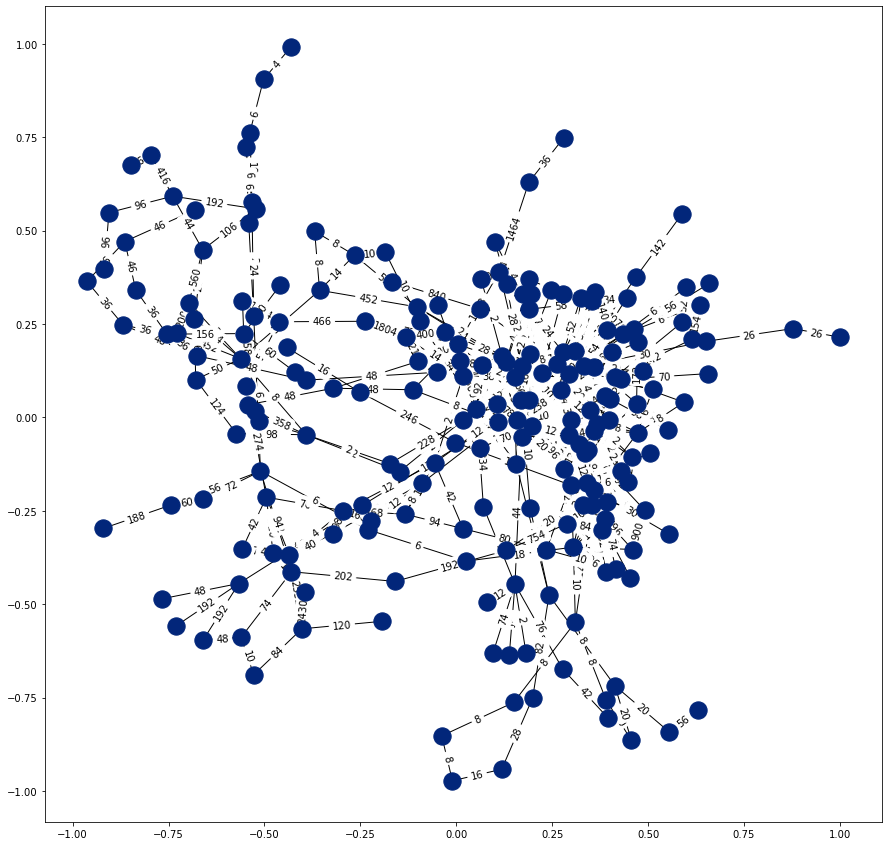

In [30]:
kept = all_cuts[211]['kept']
rest = all_cuts[211]['rest']
mc.draw_graph(kept)

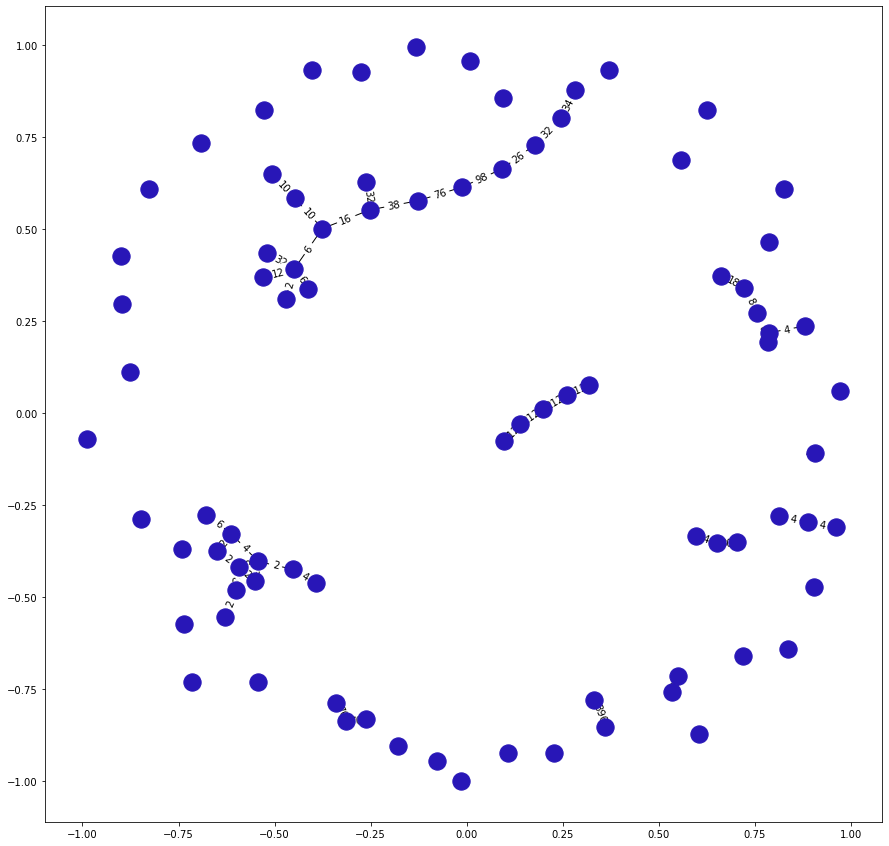

In [31]:
mc.draw_graph(rest)

In [33]:
all_cuts[211]['cut_size']

6